In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
# import audiomentations
# from audiomentations import Compose, AddGaussianNoise, PitchShift
# import torch_audiomentations
# from torch_audiomentations import Compose, AddGaussianNoise, PitchShift
import torchaudio

In [2]:
# Adapted from https://github.com/musikalkemist/pytorchforaudio
class CoughDataset(Dataset):

    def __init__(self,
                 annotations_df,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device,
                 augment=False,
                ):
        self.annotations = annotations_df
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.label_dict = {'healthy':0, 'symptomatic':1, 'COVID-19':2}
        
        self.do_augment = augment
#         self.augmentations = Compose(
#                 [
#                     AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.05, p=0.5),
#                     PitchShift(min_semitones=-8, max_semitones=8, p=0.5)
#                 ]
#         )

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self.label_dict[self._get_audio_sample_label(index)]
        signal, sr = torchaudio.load(audio_sample_path)
        
#         if self.do_augment:
#             signal = torch.from_numpy(self.augmentations(signal.numpy(), sr))
        
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])+".wav"
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 9]


In [17]:
AUDIO_DIR = "../valid_data/"
SAMPLE_RATE = 16000
NUM_SAMPLES = SAMPLE_RATE*10

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
# print(f"Using device {device}")

train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train.parquet.gzip"))
val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val.parquet.gzip"))
test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test.parquet.gzip"))

# print(f"There are {len(usd)} samples in the dataset.")
# signal, label = usd[0]

In [18]:
dataset[0][0].shape

torch.Size([1, 128, 313])

In [19]:
class CNNNetwork(torch.nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=5,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,
                out_channels=12,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(12)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=12,
                out_channels=12,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(12)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=12,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(224, 3)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_data):
        #nomralization
        std = input_data.std()
        input_data -= input_data.mean()
        input_data /= std
        
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions
    



In [42]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

def count_correct(logits, y_true):
    y_pred = torch.argmax(logits, axis = 1)
    return torch.sum(y_pred==y_true)

def train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device):
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(train_data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # calculate loss
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        
        correct_pred += count_correct(y_pred, y_batch)
        total_pred += y_batch.shape[0]

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
        
    print(f"Training loss: {total_loss}, Training accuracy : {correct_pred/total_pred}")
    
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(val_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item() 
            
        correct_pred += count_correct(y_pred, y_batch)
        total_pred += y_batch.shape[0]
        
    print(f"Validataion loss: {total_loss}, Validation accuracy : {correct_pred/total_pred}")

    
def train(model, train_data_loader, val_data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device)
        
        path = os.path.join(MODEL_FOLDER, f"epoch_{i}.pth")
        torch.save(model.state_dict(), path)
        print(f"Saved at {path}")
        print("---------------------------")
    print("Finished training")
    print("---------------------------")
    
    
def evaluate(model, eval_data_loader, loss_fn, device):
    print("Evaluating model")
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # calculate loss
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            correct_pred += count_correct(y_pred, y_batch)
            total_pred += y_batch.shape[0]

            total_loss += loss.item()
        
    print(f"Evaluation loss: {total_loss}, Evaluation accuracy : {correct_pred/total_pred}")
    print("---------------------------")

In [40]:
BATCH_SIZE =16
EPOCHS = 10
MODEL_FOLDER = '../models/'

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

train_data = CoughDataset(train_df,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

val_data = CoughDataset(val_df,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

test_data = CoughDataset(test_df,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

train_dataloader = create_data_loader(train_data, BATCH_SIZE)
val_dataloader = create_data_loader(val_data, BATCH_SIZE)
test_dataloader = create_data_loader(val_data, BATCH_SIZE)

# construct model and assign it to device
model = CNNNetwork().to(device)

# initialise loss funtion + optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters())

In [37]:
train(model, train_dataloader, val_dataloader, loss_fn, optimiser, device, EPOCHS)

Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686/686 [04:17<00:00,  2.66it/s]


Training loss: 566.4405611753464, Training accuracy : 0.7321656346321106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:24<00:00,  3.10it/s]


Validataion loss: 62.23724299669266, Validation accuracy : 0.7481542229652405
Saved at ../models/epoch_0.pth
---------------------------
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686/686 [03:56<00:00,  2.90it/s]


Training loss: 551.3338984251022, Training accuracy : 0.748038649559021


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:23<00:00,  3.33it/s]


Validataion loss: 62.21875709295273, Validation accuracy : 0.7481542229652405
Saved at ../models/epoch_1.pth
---------------------------
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686/686 [03:43<00:00,  3.06it/s]


Training loss: 550.9948009848595, Training accuracy : 0.7484948039054871


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:22<00:00,  3.45it/s]


Validataion loss: 62.20021456480026, Validation accuracy : 0.7481542229652405
Saved at ../models/epoch_2.pth
---------------------------
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686/686 [03:29<00:00,  3.27it/s]


Training loss: 550.6316012740135, Training accuracy : 0.7490421533584595


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:20<00:00,  3.81it/s]


Validataion loss: 62.28057438135147, Validation accuracy : 0.7481542229652405
Saved at ../models/epoch_3.pth
---------------------------
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686/686 [03:22<00:00,  3.38it/s]


Training loss: 550.576662003994, Training accuracy : 0.7492246031761169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:20<00:00,  3.83it/s]


Validataion loss: 62.24333715438843, Validation accuracy : 0.7473338842391968
Saved at ../models/epoch_4.pth
---------------------------
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686/686 [03:25<00:00,  3.33it/s]


Training loss: 550.0520678758621, Training accuracy : 0.7499544024467468


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:24<00:00,  3.20it/s]


Validataion loss: 62.2738618850708, Validation accuracy : 0.7481542229652405
Saved at ../models/epoch_5.pth
---------------------------
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686/686 [04:04<00:00,  2.80it/s]


Training loss: 550.184578359127, Training accuracy : 0.7501368522644043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:24<00:00,  3.18it/s]


Validataion loss: 62.26168352365494, Validation accuracy : 0.7465135455131531
Saved at ../models/epoch_6.pth
---------------------------
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686/686 [04:05<00:00,  2.79it/s]


Training loss: 550.4087800383568, Training accuracy : 0.7492246031761169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:24<00:00,  3.16it/s]


Validataion loss: 62.30344915390015, Validation accuracy : 0.7456932067871094
Saved at ../models/epoch_7.pth
---------------------------
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686/686 [04:00<00:00,  2.86it/s]


Training loss: 550.6456421613693, Training accuracy : 0.7489508986473083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:24<00:00,  3.10it/s]


Validataion loss: 62.22816425561905, Validation accuracy : 0.7473338842391968
Saved at ../models/epoch_8.pth
---------------------------
Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 686/686 [04:52<00:00,  2.35it/s]


Training loss: 549.7948590517044, Training accuracy : 0.7501368522644043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:25<00:00,  3.04it/s]

Validataion loss: 62.18648952245712, Validation accuracy : 0.7481542229652405
Saved at ../models/epoch_9.pth
---------------------------
Finished training
---------------------------


In [43]:
evaluate(model, test_dataloader, loss_fn, device)

Evaluating model


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:24<00:00,  3.15it/s]

Evaluation loss: 82.63644808530807, Evaluation accuracy : 0.38392123579978943
---------------------------


In [60]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [76]:
from sklearn.metrics import plot_confusion_matrix

def evaluate_confusion(model, eval_data_loader, device):
    trues = []
    preds =[]
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # calculate loss
            y_pred = model(x_batch)
            trues += y_batch
            preds += torch.argmax(y_pred, axis = 1)
            
    return np.array(trues), np.array(preds)
        




In [77]:
trues, preds = evaluate_confusion(model, test_dataloader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:23<00:00,  3.28it/s]


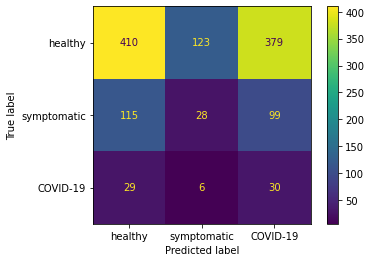

In [78]:
cfm = confusion_matrix(trues, preds)
ConfusionMatrixDisplay(cfm, display_labels=['healthy', 'symptomatic', 'COVID-19']).plot()

In [64]:
cfm

NameError: name 'cfm' is not defined

In [73]:
preds.dtype

dtype('int64')